#  CNN 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalMaxPool1D, Conv1D, Embedding, Dropout, MaxPool1D, Flatten
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import L2

In [3]:
from sklearn import feature_extraction
from sklearn import metrics
from sklearn import datasets

In [4]:
import nltk
import pickle

In [5]:
import string

In [6]:
import gensim

In [7]:
import os

In [8]:
import graphviz
import pydot

In [9]:
max_doc_len = 400

## Ucitavanje i priprema podataka

In [10]:
train_data = datasets.fetch_20newsgroups(random_state=61, remove=('headers'))
test_data = datasets.fetch_20newsgroups(random_state=61, subset='test', remove=('headers'))
X_train = train_data.data
y_train = train_data.target
X_test = test_data.data
y_test = test_data.target
feature_names = train_data.target_names
num_of_features = len(feature_names)
N_train = len(X_train)
N_test = len(X_test)

In [11]:
# ucitavamo vektorizator koji cemo koristiti za filtriranje (sadrzi vocabulary)

with open(os.path.join("models", "vectorizer.pickle"), "rb") as load_file:
    vectorizer = pickle.load(load_file)

In [12]:
vocabulary = vectorizer.vocabulary_

In [13]:
X_train_tok = [vectorizer.tokenizer(text) for text in X_train] 
X_train_tok_filt = [[word for word in text if word in vocabulary] for text in X_train_tok]

In [14]:
X_test_tok = [vectorizer.tokenizer(text) for text in X_test] 
X_test_tok_filt = [[word for word in text if word in vocabulary] for text in X_test_tok]

In [15]:
# ucitavamo vec istrenirane embedding-e

cbow_model_full = gensim.models.word2vec.Word2Vec.load(os.path.join("models", "cbow.wv"))

In [16]:
cbow = cbow_model_full.wv

In [17]:
len(cbow.key_to_index)

55487

In [18]:
# vidimo da nam fale neke reci iz originalnog vokabulara koje smo hteli da naucimo
# verovatno su se retko pojavljivale pa nisu uzete u obzir

In [19]:
dif = set([word for word in vocabulary if word not in cbow.key_to_index])
print(dif)

{"'Recommended", "'undesirables", 'Lancs', "'arms", "'meaning", '.', "'spat-out", 'Blgtn', 'T.A.S', 'Toobin', 'continuara', "'bang", "'", 'Races', 'Tayros', "'.c", 'Ala', 'YANKS'}


In [22]:
# veci nam je problem sto se 0 javlja kao indeks reci 'the' - najfrekventnije reci
# 0 cemo koristiti kao indeks za padding i nikako ne bi trebalo da predstavlja smislenu rec
# pomericemo vokabular za jedno mesto napred, a atribut maske_zero postaviti na True pri treniranju

In [23]:
cbow_vocab_plus1 = { word : cbow.key_to_index[word] + 1 for word in cbow.key_to_index}
cbow_key_to_index = cbow_vocab_plus1
cbow_index_to_key = { cbow_key_to_index[word] : word for word in cbow_key_to_index }

In [24]:
# pripremamo matricu w2v (cbow) vektora (vektor 0-te - nepostojece reci je 0 vektor - uopste nema uticaj)

In [42]:
cbow_matrix = np.vstack([np.zeros(300), cbow.vectors])

In [26]:
cbow_matrix.shape

(55487, 300)

In [28]:
# pripremamo trening i test skup

X_train_idx = [[cbow_key_to_index[word] for word in text if word in cbow_key_to_index] for text in X_train_tok_filt]

In [29]:
X_test_idx = [[cbow_key_to_index[word] for word in text if word in cbow_key_to_index ] for text in X_test_tok_filt]

In [29]:
# vrsimo odsecanje na 400 reci i pre-padding nulama

In [30]:
X_train_input = pad_sequences(X_train_idx, maxlen=max_doc_len)
X_test_input = pad_sequences(X_test_idx, maxlen=max_doc_len)

In [31]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

## CNN

### CNN modeli

Modeli sa vec spremnim embedingom (word2vec)
1. CNN1 (filter_size=1, num_of_filters=600)
2. CNN2 (filter_size=2, num_of_filters=800)
3. CNN3 (filter_size=3, num_of_filters=600)

Modeli kod kojih treniramo i embeding

4. CNN1e (filter_size=1, num_of_filters=600)
5. CNN2e (filter_size=2, num_of_filters=800)
6. CNN3e (filter_size=3, num_of_filters=600)

Eksperimentalni modeli (sa i bez ranije treniranog embedinga)

7. CNN5 (filter_size=5, num_of_filters=600)
8. CNN5e (filter_size=5, num_of_filters=600)

In [32]:
def plot_train_val_performance(history):

    plt.figure(figsize=(10, 4))

    plt.subplot(121)
    plt.title('Loss')
    plt.plot(history.epoch, history.history['loss'], label='train')
    plt.plot(history.epoch, history.history['val_loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(122)
    plt.title('Accuracy')
    plt.plot(history.epoch, history.history['accuracy'], label='train')
    plt.plot(history.epoch, history.history['val_accuracy'], label='val')
    plt.legend(loc='best')

    plt.show()

In [33]:
embedding_dim = 300

In [34]:
# vocab size
V = len(cbow_index_to_key)

In [93]:
def train_model(filter_size=1, filters=600, batch_size=128, epochs=20, learning_rate=0.0001, dropout_rate=0.25, val_split=0.1, l2=0.1, embedding_trainable=False):
    embedding_layer = Embedding(input_dim=V+1, output_dim=embedding_dim, input_length=max_doc_len, mask_zero=True,
                               trainable=embedding_trainable, weights=[cbow_matrix])
    dropout_layer = Dropout(dropout_rate)
    conv_layer = Conv1D(filters, filter_size, activation='relu', kernel_regularizer=L2(1))
    global_max_pool_layer = GlobalMaxPool1D()
    dense_layer = Dense(20, activation='softmax', activity_regularizer=L2(l2))
    
        
        
    cnn = Sequential([
        embedding_layer,
        dropout_layer,
        conv_layer,
        global_max_pool_layer,
        Dropout(0.5),
        dense_layer
    ])
    
    cnn.compile(optimizer=Adam(learning_rate=learning_rate), loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])
    
    print(cnn.summary(), "\n")
    
    history = cnn.fit(X_train_input, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=val_split, verbose=1)
    
    return cnn, history
    
    
        
        
        

In [56]:
def test_model(cnn, history, x_test):
    print(cnn.summary())
    plot_train_val_performance(history)
    
    score = cnn.evaluate(x_test, y_test_cat)
    test_loss = score[0]
    #Ovo je bitno
    test_accuracy = score[1]
    
    print("Test loss: ", test_loss)
    print("Test accuracy: ", test_accuracy, "\n")
    
    
    y_predicted = cnn.predict(X_test_input)
    y_predicted_int = np.array([yp.argmax() for yp in y_predicted])
                                                        #uvezi feature_names.txt i dodaj target_names=feature_names
    print("Classification report: ", metrics.classification_report(y_test, y_predicted_int))
    
    
    confusion_matrix = metrics.confusion_matrix(y_test, y_predicted_int)
    
    #poigraj se tu malo sa matricom konfuzije
    #print(confusion_matrix)

In [92]:
model, history = train_model(filter_size=2, filters=800, batch_size=128, epochs=15, learning_rate=0.0001, dropout_rate=0.2, l2=0.1)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 400, 300)          16646400  
                                                                 
 conv1d_14 (Conv1D)          (None, 399, 800)          480800    
                                                                 
 global_max_pooling1d_14 (Gl  (None, 800)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_14 (Dense)            (None, 20)                16020     
                                                                 
Total params: 17,143,220
Trainable params: 496,820
Non-trainable params: 16,646,400
_________________________________________________________________
None 

Epoch 1/15
80/80 [==============================] - 32s 398ms/step - loss: 354.0132 - accuracy

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 400, 300)          16646400  
                                                                 
 dropout_15 (Dropout)        (None, 400, 300)          0         
                                                                 
 conv1d_9 (Conv1D)           (None, 399, 800)          480800    
                                                                 
 global_max_pooling1d_9 (Glo  (None, 800)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_16 (Dropout)        (None, 800)               0         
                                                                 
 dense_9 (Dense)             (None, 20)                16020     
                                                      

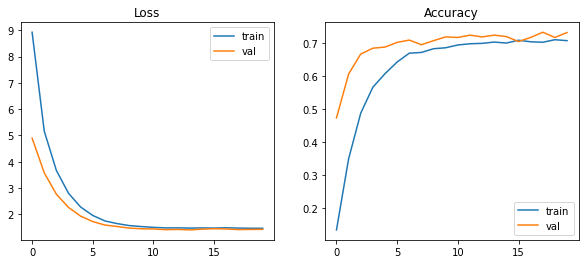

236/236 [==============================] - 9s 39ms/step - loss: 1.5984 - accuracy: 0.6783
Test loss:  1.5984007120132446
Test accuracy:  0.6783059239387512 

236/236 [==============================] - 9s 39ms/step
Classification report:                precision    recall  f1-score   support

           0       0.49      0.58      0.53       319
           1       0.54      0.60      0.57       389
           2       0.69      0.61      0.65       394
           3       0.55      0.58      0.57       392
           4       0.68      0.61      0.64       385
           5       0.62      0.76      0.68       395
           6       0.69      0.85      0.76       390
           7       0.81      0.71      0.75       396
           8       0.84      0.83      0.84       398
           9       0.75      0.77      0.76       397
          10       0.82      0.86      0.84       399
          11       0.79      0.81      0.80       396
          12       0.57      0.44      0.50       393
     

In [84]:
test_model(model, history, X_test_input)

In [74]:
model_emb, history = train_model(filter_size=3, filters=600, batch_size=128, epochs=10, learning_rate=0.001, dropout_rate=0.2, l2=0.01, embedding_trainable=True)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 400, 300)          16646400  
                                                                 
 dropout_11 (Dropout)        (None, 400, 300)          0         
                                                                 
 conv1d_7 (Conv1D)           (None, 398, 600)          540600    
                                                                 
 global_max_pooling1d_7 (Glo  (None, 600)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_12 (Dropout)        (None, 600)               0         
                                                                 
 dense_7 (Dense)             (None, 20)                12020     
                                                      

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 400, 300)          16646400  
                                                                 
 dropout_11 (Dropout)        (None, 400, 300)          0         
                                                                 
 conv1d_7 (Conv1D)           (None, 398, 600)          540600    
                                                                 
 global_max_pooling1d_7 (Glo  (None, 600)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_12 (Dropout)        (None, 600)               0         
                                                                 
 dense_7 (Dense)             (None, 20)                12020     
                                                      

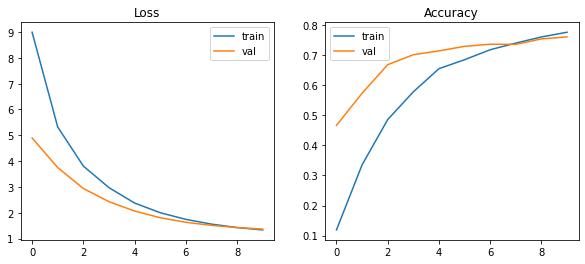

236/236 [==============================] - 10s 43ms/step - loss: 1.5921 - accuracy: 0.6903
Test loss:  1.5920699834823608
Test accuracy:  0.6902549266815186 

236/236 [==============================] - 10s 44ms/step
Classification report:                precision    recall  f1-score   support

           0       0.74      0.43      0.54       319
           1       0.57      0.64      0.60       389
           2       0.74      0.57      0.64       394
           3       0.56      0.62      0.59       392
           4       0.61      0.72      0.66       385
           5       0.67      0.72      0.69       395
           6       0.74      0.78      0.76       390
           7       0.84      0.67      0.75       396
           8       0.86      0.85      0.85       398
           9       0.77      0.78      0.78       397
          10       0.85      0.84      0.85       399
          11       0.86      0.77      0.82       396
          12       0.50      0.55      0.53       393
   

In [75]:
test_model(model_emb, history, X_test_input)

In [79]:
model_path = os.path.join("models", "test_model_emb.hdf5")

In [80]:
model_emb.save(model_path)

In [46]:
def prepare_input(text):
    text = vectorizer.tokenizer(text)
    text_idx = np.array([cbow_key_to_index[word] if word in cbow_key_to_index else 0 for word in text])
    text_idx_padded = pad_sequences([text_idx], maxlen=max_doc_len)[0]
    
    return np.array([text_idx_padded])

In [47]:
test_input = "Hello are you interested in a conversation about our Lord Jesus Christ, our saviour? Praise be."

In [48]:
feature_names[np.argmax(model.predict(prepare_input(test_input)))]

1/1 [==============================] - 0s 17ms/step


'soc.religion.christian'